In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

Leemos los datos y vemos las primeras entradas:

In [2]:
df = pd.read_csv("./CarPrice_Assignment.csv")
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Generamos un reporte básico:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Podemos ver que no tenemos valores nulos, y que hay columnas tanto numéricas como textuales. Empezamos seleccionando las columnas categóricas, utilizando la descripción de nuestro conjunto de datos:

## Dimensiones categóricas

In [4]:
cat_cols = [
    'symboling', 
    'CarName',
    'fueltype', 
    'aspiration',
    'doornumber',
    'carbody',
    'drivewheel',
    'enginelocation',
    'enginetype',
    'cylindernumber',
    'fuelsystem',
    ]
df_cat = df[cat_cols].copy()
df_cat.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2,audi 100ls,gas,std,four,sedan,4wd,front,ohc,five,mpfi


Calculamos el número de valores únicos por cada columna:

In [5]:
[(c, len(df_cat[c].unique())) for c in df_cat.columns]

[('symboling', 6),
 ('CarName', 147),
 ('fueltype', 2),
 ('aspiration', 2),
 ('doornumber', 2),
 ('carbody', 5),
 ('drivewheel', 3),
 ('enginelocation', 2),
 ('enginetype', 7),
 ('cylindernumber', 7),
 ('fuelsystem', 8)]

Vemos que la columna de `CarName` tiene demasiados valores diferentes como para ser útil, así que la eliminamos:

In [6]:
df_cat = df_cat.drop('CarName', axis=1)
df_cat.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2,gas,std,four,sedan,4wd,front,ohc,five,mpfi


Las columnas `doornumber` y `cylindernumber` pueden ser convertidas a números:

In [7]:
df_cat['doornumber'] = df_cat['doornumber'].map({'two': 2, 'four':4})
df_cat['cylindernumber'] = df_cat['cylindernumber'].map({'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'eight': 8, 'twelve': 12})

In [8]:
df_cat.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,3,gas,std,2,convertible,rwd,front,dohc,4,mpfi
1,3,gas,std,2,convertible,rwd,front,dohc,4,mpfi
2,1,gas,std,2,hatchback,rwd,front,ohcv,6,mpfi
3,2,gas,std,4,sedan,fwd,front,ohc,4,mpfi
4,2,gas,std,4,sedan,4wd,front,ohc,5,mpfi


Grafiquemos cómo se ve la distribución del precio vs. cada una de las categorías:

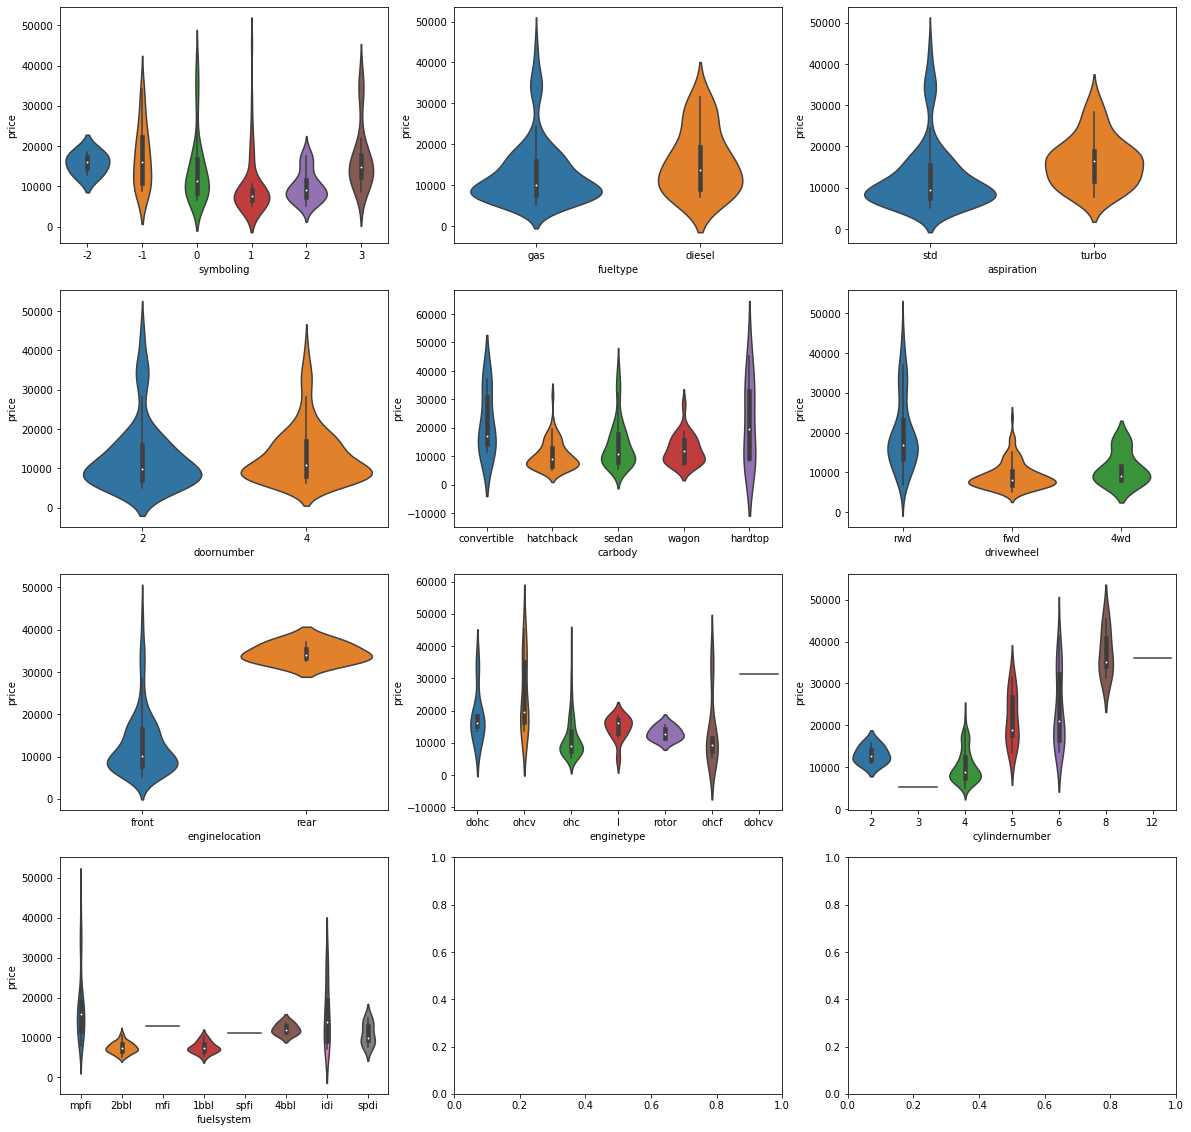

In [9]:
fig, ax = plt.subplots(4, 3, figsize=(20,20))
for i, c in enumerate(df_cat.columns):
    sns.violinplot(x=df_cat[c], y=df['price'], ax=ax[i//3][i%3])

La distribución del precio en relación al número de puertas es prácticamente idéntica para ambas categorías, así que la quitamos:

In [10]:
df_cat = df_cat.drop('doornumber', axis=1)

Vemos la distribución de cada categoría:

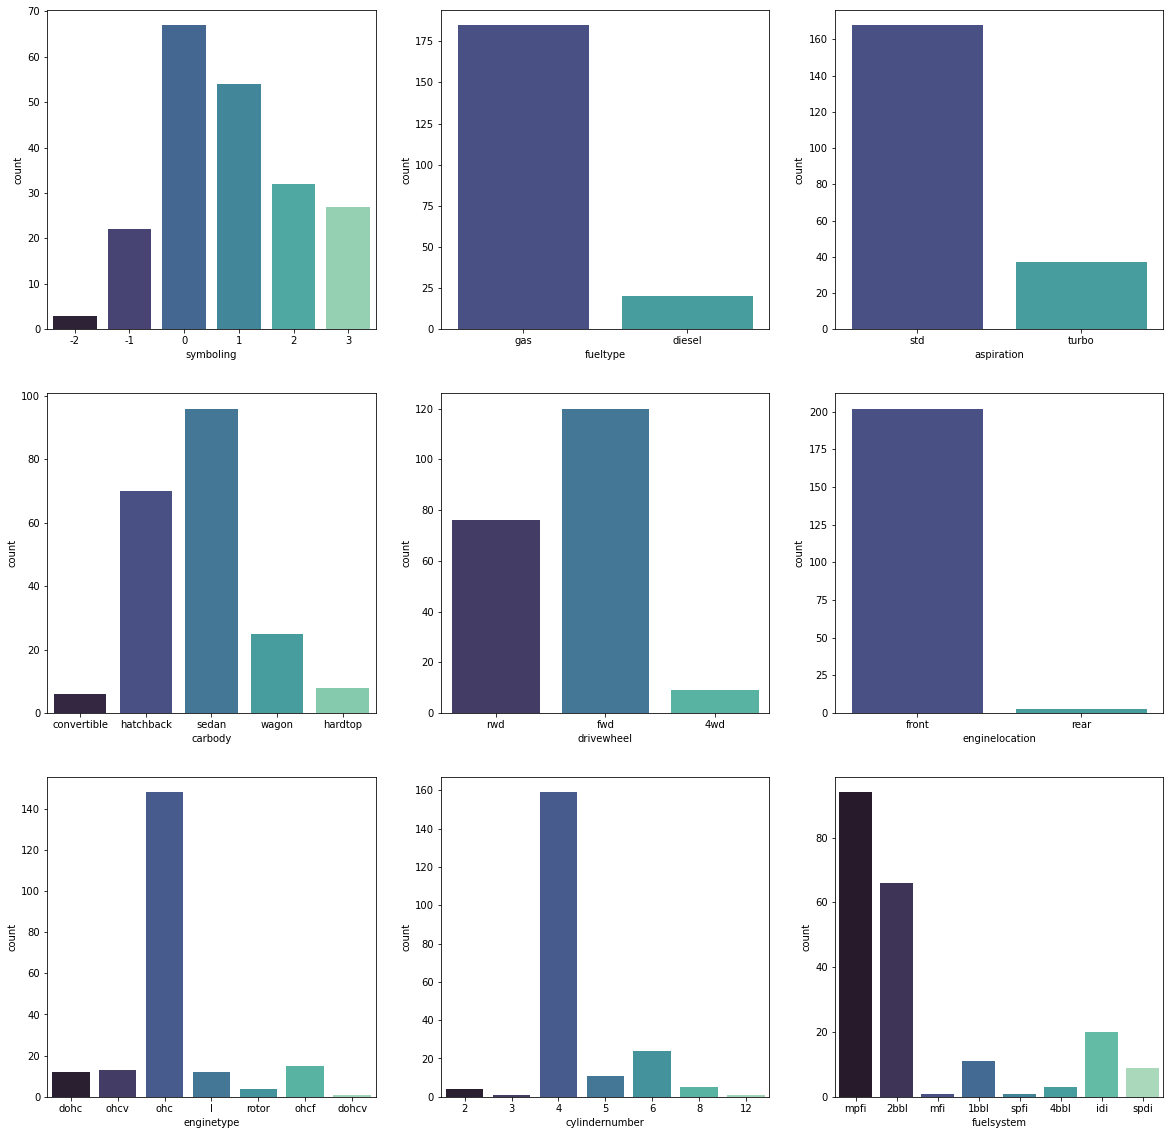

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(20,20))
for i, c in enumerate(df_cat.columns):
    sns.countplot(x=df_cat[c], ax=ax[i//3][i%3], palette='mako')

`enginelocation` está demasiado sesgada, así que la eliminamos:

In [12]:
df_cat = df_cat.drop('enginelocation', axis=1)

Removemos las columnas numéricas que convertimos (`cylindernumber` y `symboling`) para quedarnos con las verdaderamente categóricas:

In [13]:
df_extra = df_cat[['symboling', 'cylindernumber']].copy()
df_cat = df_cat.drop(['symboling', 'cylindernumber'], axis=1)
df_cat.head()

,fueltype,aspiration,carbody,drivewheel,enginetype,fuelsystem
0,gas,std,convertible,rwd,dohc,mpfi
1,gas,std,convertible,rwd,dohc,mpfi
2,gas,std,hatchback,rwd,ohcv,mpfi
3,gas,std,sedan,fwd,ohc,mpfi
4,gas,std,sedan,4wd,ohc,mpfi


Convertimos nuestras columnas categóricas a one-hot encoding:

In [14]:
df_cat = pd.get_dummies(df_cat)
df_cat.head()

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,...,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


## Dimensiones numéricas

Tomamos ahora las columnas faltantes:

In [15]:
num_cols = set(df.columns) - set(cat_cols) 
df_num = df[num_cols].copy()
df_num.head()

,stroke,wheelbase,horsepower,curbweight,carwidth,compressionratio,carheight,citympg,carlength,car_ID,enginesize,boreratio,price,peakrpm,highwaympg
0,2.68,88.6,111,2548,64.1,9.0,48.8,21,168.8,1,130,3.47,13495.0,5000,27
1,2.68,88.6,111,2548,64.1,9.0,48.8,21,168.8,2,130,3.47,16500.0,5000,27
2,3.47,94.5,154,2823,65.5,9.0,52.4,19,171.2,3,152,2.68,16500.0,5000,26
3,3.40,99.8,102,2337,66.2,10.0,54.3,24,176.6,4,109,3.19,13950.0,5500,30
4,3.40,99.4,115,2824,66.4,8.0,54.3,18,176.6,5,136,3.19,17450.0,5500,22


Añadimos las que encontramos en la sección anterior:

In [16]:
df_num = pd.concat([df_num, df_extra], axis=1)
df_num.head()

,stroke,wheelbase,horsepower,curbweight,carwidth,compressionratio,carheight,citympg,carlength,car_ID,enginesize,boreratio,price,peakrpm,highwaympg,symboling,cylindernumber
0,2.68,88.6,111,2548,64.1,9.0,48.8,21,168.8,1,130,3.47,13495.0,5000,27,3,4
1,2.68,88.6,111,2548,64.1,9.0,48.8,21,168.8,2,130,3.47,16500.0,5000,27,3,4
2,3.47,94.5,154,2823,65.5,9.0,52.4,19,171.2,3,152,2.68,16500.0,5000,26,1,6
3,3.40,99.8,102,2337,66.2,10.0,54.3,24,176.6,4,109,3.19,13950.0,5500,30,2,4
4,3.40,99.4,115,2824,66.4,8.0,54.3,18,176.6,5,136,3.19,17450.0,5500,22,2,5


Quitamos `car_ID`:

In [17]:
df_num = df_num.drop('car_ID', axis=1)
df_num.head()

,stroke,wheelbase,horsepower,curbweight,carwidth,compressionratio,carheight,citympg,carlength,enginesize,boreratio,price,peakrpm,highwaympg,symboling,cylindernumber
0,2.68,88.6,111,2548,64.1,9.0,48.8,21,168.8,130,3.47,13495.0,5000,27,3,4
1,2.68,88.6,111,2548,64.1,9.0,48.8,21,168.8,130,3.47,16500.0,5000,27,3,4
2,3.47,94.5,154,2823,65.5,9.0,52.4,19,171.2,152,2.68,16500.0,5000,26,1,6
3,3.40,99.8,102,2337,66.2,10.0,54.3,24,176.6,109,3.19,13950.0,5500,30,2,4
4,3.40,99.4,115,2824,66.4,8.0,54.3,18,176.6,136,3.19,17450.0,5500,22,2,5


Calculamos su correlación con respecto a la variable `price`:

<AxesSubplot:xlabel='price'>

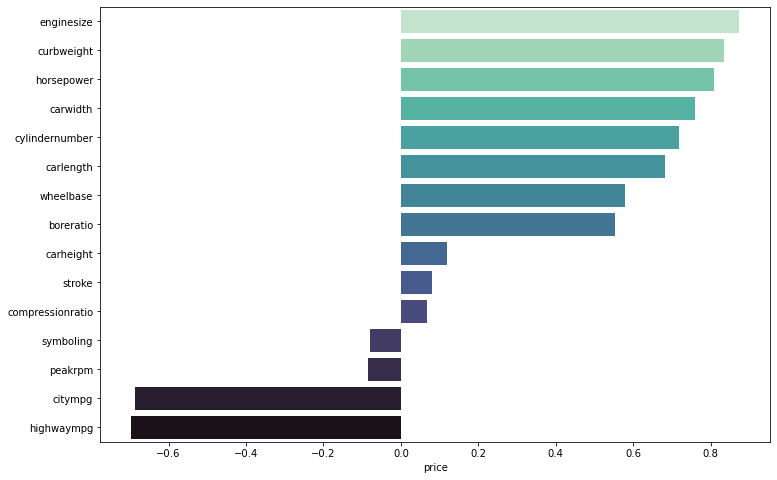

In [18]:
corr = df_num.corr()['price'].sort_values(ascending=False)
corr = corr.drop('price')
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(y=corr.index, x=corr, ax=ax, palette='mako_r')

Podemos ver que hay 5 variables con una correlación muy pequeña, así que las eliminamos:

In [19]:
corr_abs = corr.abs()
corr_abs = corr_abs.sort_values()
corr_abs = list(corr_abs[:5].index)
df_num = df_num.drop(corr_abs, axis=1)
df_num.head()

,wheelbase,horsepower,curbweight,carwidth,citympg,carlength,enginesize,boreratio,price,highwaympg,cylindernumber
0,88.6,111,2548,64.1,21,168.8,130,3.47,13495.0,27,4
1,88.6,111,2548,64.1,21,168.8,130,3.47,16500.0,27,4
2,94.5,154,2823,65.5,19,171.2,152,2.68,16500.0,26,6
3,99.8,102,2337,66.2,24,176.6,109,3.19,13950.0,30,4
4,99.4,115,2824,66.4,18,176.6,136,3.19,17450.0,22,5


Graficando la distribución de cada variable:

array([[<AxesSubplot:title={'center':'wheelbase'}>,
        <AxesSubplot:title={'center':'horsepower'}>,
        <AxesSubplot:title={'center':'curbweight'}>],
       [<AxesSubplot:title={'center':'carwidth'}>,
        <AxesSubplot:title={'center':'citympg'}>,
        <AxesSubplot:title={'center':'carlength'}>],
       [<AxesSubplot:title={'center':'enginesize'}>,
        <AxesSubplot:title={'center':'boreratio'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'highwaympg'}>,
        <AxesSubplot:title={'center':'cylindernumber'}>, <AxesSubplot:>]],
      dtype=object)

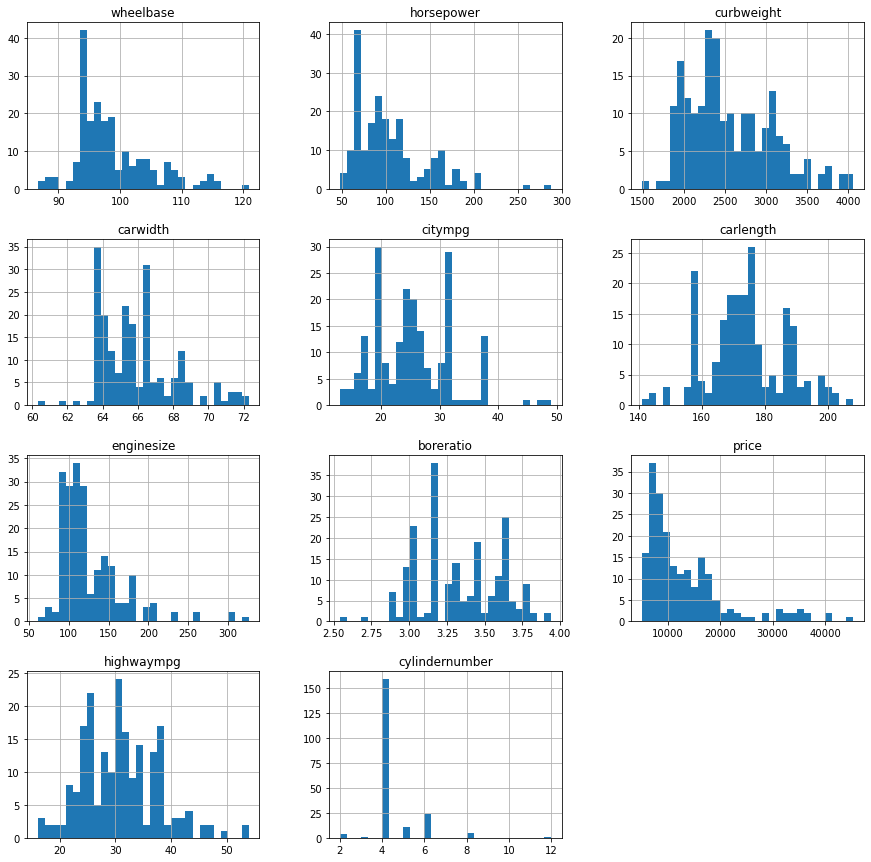

In [20]:
df_num.hist(bins=30, figsize=(15,15))

Ninguna variable está excesivamente sesgada, así que no eliminamos nada.

Finalmente, estandarizamos las dimensiones (con la excepción de `cylindernumber` y `price`):

In [21]:
temp = df_num.drop(['cylindernumber', 'price'], axis=1)

sc = StandardScaler()
temp = sc.fit_transform(temp)

df_num.loc[:, (df_num.columns != 'cylindernumber') & (df_num.columns != 'price')] = temp

Visualizando de nuevo los histogramas:

array([[<AxesSubplot:title={'center':'wheelbase'}>,
        <AxesSubplot:title={'center':'horsepower'}>,
        <AxesSubplot:title={'center':'curbweight'}>],
       [<AxesSubplot:title={'center':'carwidth'}>,
        <AxesSubplot:title={'center':'citympg'}>,
        <AxesSubplot:title={'center':'carlength'}>],
       [<AxesSubplot:title={'center':'enginesize'}>,
        <AxesSubplot:title={'center':'boreratio'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'highwaympg'}>,
        <AxesSubplot:title={'center':'cylindernumber'}>, <AxesSubplot:>]],
      dtype=object)

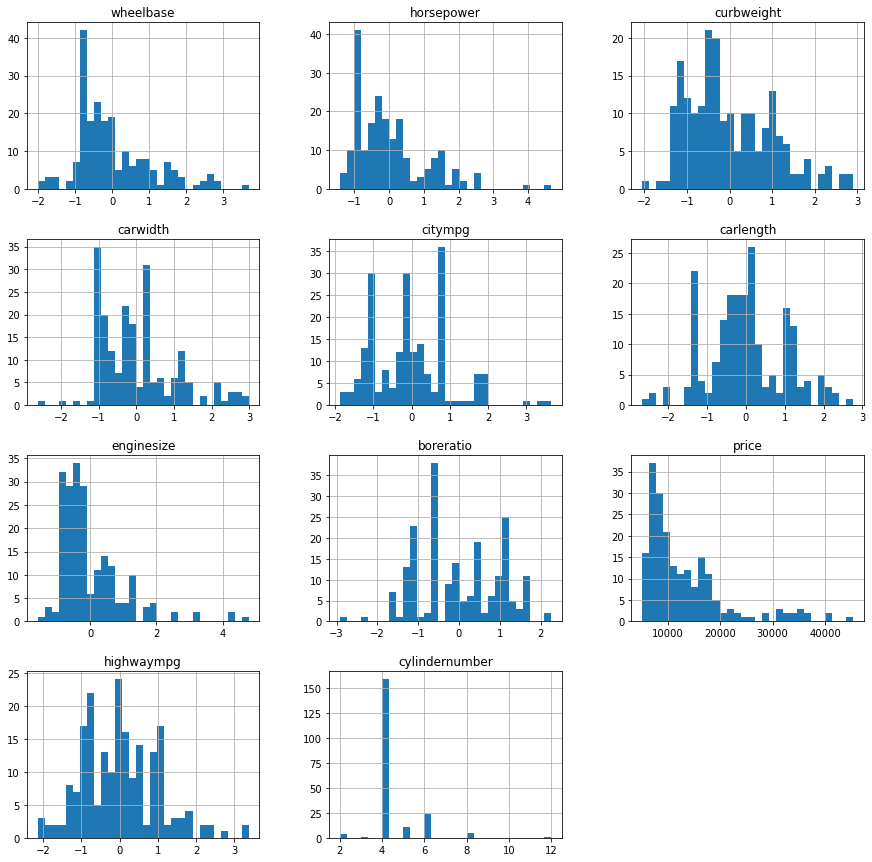

In [22]:
df_num.hist(bins=30, figsize=(15,15))

Podemos ver que ahora todas las distribuciones están centradas.

## Juntándolo todo

Con esto, tenemos un primer esbozo de nuestras variables dependientes. Unimos la dos DataFrames obtenidas:

In [23]:
df_tot = pd.concat([df_cat, df_num], axis=1)
df_tot.head()

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,...,horsepower,curbweight,carwidth,citympg,carlength,enginesize,boreratio,price,highwaympg,cylindernumber
0,0,1,1,0,1,0,0,0,0,0,...,0.174483,-0.014566,-0.844782,-0.646553,-0.426521,0.074449,0.519071,13495.0,-0.546059,4
1,0,1,1,0,1,0,0,0,0,0,...,0.174483,-0.014566,-0.844782,-0.646553,-0.426521,0.074449,0.519071,16500.0,-0.546059,4
2,0,1,1,0,0,0,1,0,0,0,...,1.264536,0.514882,-0.190566,-0.953012,-0.231513,0.604046,-2.404880,16500.0,-0.691627,6
3,0,1,1,0,0,0,0,1,0,0,...,-0.053668,-0.420797,0.136542,-0.186865,0.207256,-0.431076,-0.517266,13950.0,-0.109354,4
4,0,1,1,0,0,0,0,1,0,1,...,0.275883,0.516807,0.230001,-1.106241,0.207256,0.218885,-0.517266,17450.0,-1.273900,5


Separamos en variables dependientes e independientes:

In [24]:
X = df_tot.drop('price', axis=1).copy()
y = df_tot['price'].copy()

# Regresión

## Simple

Hacemos la regresión utilizando todas las variables de entrada:

In [25]:
model0 = sm.OLS(y, sm.add_constant(X))
res0 = model0.fit()
res0.summary()

/home/bondrewd/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     48.87
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           1.86e-69
Time:                        11:50:50   Log-Likelihood:                -1902.5
No. Observations:                 205   AIC:                             3867.
Df Residuals:                     174   BIC:                             3970.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4165.3915   1133.871      3.674      0.000    1927.481    6403.302
fueltype_diesel      1890.8968    617.797      3.061      0.003     671.557    3110.237
fueltype_gas         2274.4947    840.501      2.706      0.007     615.606    3933.384
aspiration_std       1791.6104    752.233      2.382      0.018     306.935    3276.286
aspiration_turbo     2373.7810    746.019      3.182      0.002     901.370    3846.192
carbody_convertible  5577.7611   1185.253      4.706      0.000    3238.438    7917.084
carbody_hardtop       543.4628    959.076      0.567      0.572   -1349.458    2436.384
carbody_hatchback   -1025.8994    534.815     -1.918      0.057   -2081.459      29.660
carbody_sedan          75.6613    565.712      0.134      0.894   -1040.880    1192.203
carbody_wagon       -1005.5944    804.195     -1.250      0.213   -2592.828     581.639
drivewheel_4wd        866.2424    975.173      0.888      0.376   -1058.448    2790.933
drivewheel_fwd        638.4606    567.221      1.126      0.262    -481.058    1757.979
drivewheel_rwd       2660.6884    717.712      3.707      0.000    1244.147    4077.230
enginetype_dohc     -1649.4974   1121.569     -1.471      0.143   -3863.128     564.133
enginetype_dohcv    -4601.2377   3667.039     -1.255      0.211   -1.18e+04    2636.367
enginetype_l          212.5836   1271.186      0.167      0.867   -2296.345    2721.512
enginetype_ohc       1887.7526    872.084      2.165      0.032     166.528    3608.977
enginetype_ohcf      4881.4896   1205.219      4.050      0.000    2502.760    7260.220
enginetype_ohcv     -3960.0962   1343.579     -2.947      0.004   -6611.906   -1308.286
enginetype_rotor     7394.3970   2869.701      2.577      0.011    1730.492    1.31e+04
fuelsystem_1bbl      1380.8261   1139.832      1.211      0.227    -868.850    3630.502
fuelsystem_2bbl      1498.7680    887.577      1.689      0.093    -253.036    3250.572
fuelsystem_4bbl      1322.2000   2929.836      0.451      0.652   -4460.391    7104.791
fuelsystem_idi       1890.8968    617.797      3.061      0.003     671.557    3110.237
fuelsystem_mfi      -2492.9908   2651.469     -0.940      0.348   -7726.173    2740.191
fuelsystem_mpfi      1028.6099    887.506      1.159      0.248    -723.054    2780.274
fuelsystem_spdi     -1683.2355   1197.959     -1.405      0.162   -4047.636     681.165
fuelsystem_spfi      1220.3170   2645.433      0.461      0.645   -4000.952    6441.586
wheelbase            1032.2856    607.264      1.700      0.091    -166.265    2230.837
horsepower           2835.3723    818.827      3.463      0.001    1219.261    4451.484
curbweight           1046.3691   1071.354      0.977      0.330   -1068.152    3160.891
carwidth             1254.9941    548.839      2.287      0.023     171.756    2338.232
cit

Definimos una función para generar algunas estadísticas y evaluamos en el conjunto de prueba:

## LASSO

Primero, ajustamos un modelo LASSO a las variables:

In [26]:
lasso = Lasso()
lasso.fit(X, y)

Lasso()

Nos quedamos con las 10 dimensiones con coeficientes mayores (en valor absoluto):

In [27]:
abs_ind = np.argsort(np.abs(lasso.coef_))[:-11:-1]
ind = [x in abs_ind for x in range(37)]

X_lasso = X.loc[:, ind]
X_lasso.head()

,carbody_convertible,enginetype_dohc,enginetype_dohcv,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_mfi,fuelsystem_spdi,horsepower,enginesize
0,1,1,0,0,0,0,0,0,0.174483,0.074449
1,1,1,0,0,0,0,0,0,0.174483,0.074449
2,0,0,0,0,1,0,0,0,1.264536,0.604046
3,0,0,0,0,0,0,0,0,-0.053668,-0.431076
4,0,0,0,0,0,0,0,0,0.275883,0.218885


Ajustamos el modelo:

In [28]:
model1 = sm.OLS(y, sm.add_constant(X_lasso))
res1 = model1.fit()
res1.summary()

/home/bondrewd/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     112.8
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           3.14e-75
Time:                        11:50:50   Log-Likelihood:                -1935.8
No. Observations:                 205   AIC:                             3894.
Df Residuals:                     194   BIC:                             3930.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  1.4e+04    273.936     51.103      0.000    1.35e+04    1.45e+04
carbody_convertible  4121.1739   1340.200      3.075      0.002    1477.941    6764.407
enginetype_dohc     -3859.3599   1044.953     -3.693      0.000   -5920.287   -1798.433
enginetype_dohcv    -6265.6753   3577.547     -1.751      0.081   -1.33e+04     790.204
enginetype_ohcf      -612.7649    869.731     -0.705      0.482   -2328.107    1102.577
enginetype_ohcv     -6733.7956   1140.263     -5.905      0.000   -8982.698   -4484.893
enginetype_rotor     6542.4503   1726.549      3.789      0.000    3137.233    9947.668
fuelsystem_mfi      -8062.8389   3174.613     -2.540      0.012   -1.43e+04   -1801.652
fuelsystem_spdi     -4622.6954   1125.319     -4.108      0.000   -6842.126   -2403.265
horsepower           2709.5954    465.672      5.819      0.000    1791.167    3628.024
enginesize           6025.1111    455.833     13.218      0.000    5126.087    6924.135
==============================================================================
Omnibus:                        8.108   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               14.932
Skew:                           0.052   Prob(JB):                     0.000572
Kurtosis:                       4.318   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## LASSO + RFE

Esta vez, utilizamos Recursive Feature Elimination: este método consiste en entrenar un estimador (LASSO, en nuestro caso) sobre nuestro conjunto de variables completo. Después, aquellas con los pesos más pequeños son eliminadas, y el procedimiento se repite hasta que solo quede el número deseado de características.

In [29]:
lasso = Lasso()
rfe = RFE(lasso, n_features_to_select=10)

rfe.fit(X, y)

RFE(estimator=Lasso(), n_features_to_select=10)

Con esto, obtenemos:

In [30]:
X_rfe = X.loc[:,rfe.support_]
X_rfe.head()

,carbody_convertible,enginetype_dohc,enginetype_dohcv,enginetype_ohcv,enginetype_rotor,fuelsystem_mfi,fuelsystem_spdi,horsepower,carwidth,enginesize
0,1,1,0,0,0,0,0,0.174483,-0.844782,0.074449
1,1,1,0,0,0,0,0,0.174483,-0.844782,0.074449
2,0,0,0,1,0,0,0,1.264536,-0.190566,0.604046
3,0,0,0,0,0,0,0,-0.053668,0.136542,-0.431076
4,0,0,0,0,0,0,0,0.275883,0.230001,0.218885


Ajustando la regresión:

In [31]:
model2 = sm.OLS(y, sm.add_constant(X_rfe))
res2 = model2.fit()
res2.summary()

/home/bondrewd/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           2.89e-79
Time:                        11:50:50   Log-Likelihood:                -1925.9
No. Observations:                 205   AIC:                             3874.
Df Residuals:                     194   BIC:                             3910.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.383e+04    247.455     55.898      0.000    1.33e+04    1.43e+04
carbody_convertible  4983.8639   1290.013      3.863      0.000    2439.612    7528.115
enginetype_dohc     -3160.6764    992.020     -3.186      0.002   -5117.204   -1204.149
enginetype_dohcv    -7627.5680   3406.954     -2.239      0.026   -1.43e+04    -908.143
enginetype_ohcv     -5886.3608   1092.342     -5.389      0.000   -8040.752   -3731.970
enginetype_rotor     5400.1085   1661.106      3.251      0.001    2123.963    8676.254
fuelsystem_mfi      -7191.8050   3026.851     -2.376      0.018   -1.32e+04   -1222.045
fuelsystem_spdi     -4012.4517   1070.380     -3.749      0.000   -6123.527   -1901.376
horsepower           2530.1793    436.486      5.797      0.000    1669.313    3391.046
carwidth             1483.6607    330.217      4.493      0.000     832.384    2134.938
enginesize           4896.8373    503.429      9.727      0.000    3903.941    5889.733
==============================================================================
Omnibus:                        7.478   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               10.872
Skew:                           0.197   Prob(JB):                      0.00436
Kurtosis:                       4.057   Cond. No.                         26.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## LASSO + RFE + CV

Ahora, usamos 5-fold cross-validation para seleccionar el mejor número de características:

In [32]:
lasso = Lasso()
rfe = RFECV(lasso, cv=5)
rfe.fit(X, y)

RFECV(cv=5, estimator=Lasso())

Con lo que obtenemos:

In [33]:
X_rfe_cv = X.loc[:,rfe.support_]
X_rfe_cv.head()

,enginetype_rotor,enginesize
0,0,0.074449
1,0,0.074449
2,0,0.604046
3,0,-0.431076
4,0,0.218885


Realizando la regresión:

In [34]:
model3 = sm.OLS(y, sm.add_constant(X_rfe_cv))
res3 = model3.fit()
res3.summary()

/home/bondrewd/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     379.1
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           4.17e-69
Time:                        11:50:51   Log-Likelihood:                -1972.7
No. Observations:                 205   AIC:                             3951.
Df Residuals:                     202   BIC:                             3961.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.309e+04    259.812     50.398      0.000    1.26e+04    1.36e+04
enginetype_rotor  9363.4125   1891.903      4.949      0.000    5633.001    1.31e+04
enginesize        7205.6480    261.681     27.536      0.000    6689.670    7721.626
==============================================================================
Omnibus:                       19.841   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.650
Skew:                           0.519   Prob(JB):                     2.99e-08
Kurtosis:                       4.726   Cond. No.                         7.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Resultados

Resumimos lo obtenido con los distintos modelos:

Text(0.5, 1.0, 'Número de coeficientes')

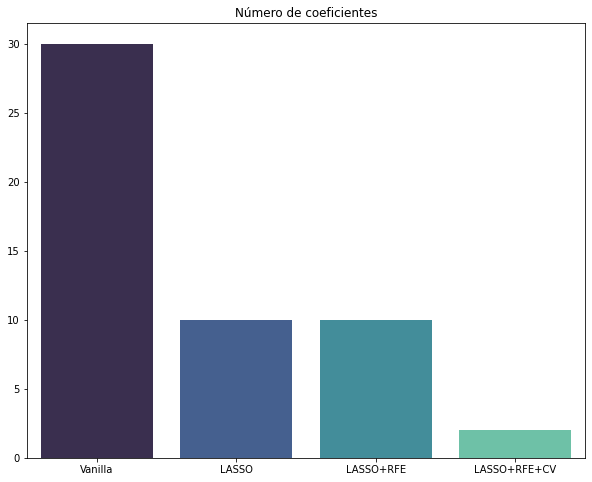

In [35]:
names = ['Vanilla', 'LASSO', 'LASSO+RFE', 'LASSO+RFE+CV']
param_list = [model0.rank-1, model1.rank-1, model2.rank-1, model3.rank-1]

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=names, y=param_list, palette='mako')
ax.set_title("Número de coeficientes")

Text(0.5, 1.0, 'Estadísticas de ajuste')

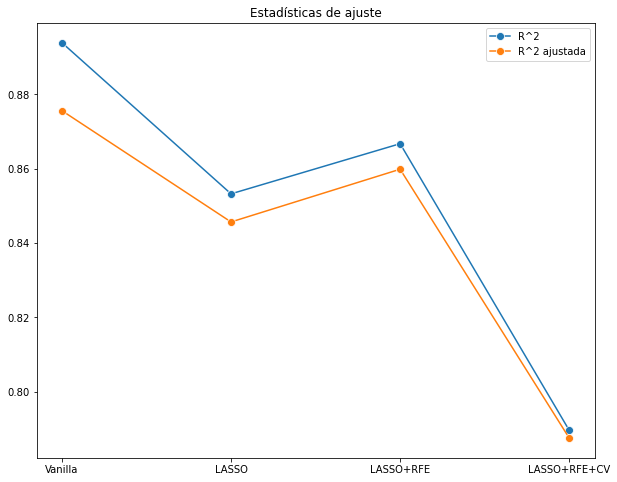

In [36]:
r_list = [res0.rsquared, res1.rsquared, res2.rsquared, res3.rsquared]
r_adj_list = [res0.rsquared_adj, res1.rsquared_adj, res2.rsquared_adj, res3.rsquared_adj]

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x=names, y=r_list, markers=True, marker='o', markersize=8, label='R^2', ax=ax, palette='mako')
sns.lineplot(x=names, y=r_adj_list, markers=True, marker='o', markersize=8, label='R^2 ajustada', ax=ax, palette='mako')
ax.set_title("Estadísticas de ajuste")

Si bien el modelo vainilla da los mejores resultados, el número de parámetros que usa es prohibitivo. Por lo tanto, tomamos el producido por LASSO + RFE

Recordando el `summary` generado:

In [37]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 14 Sep 2021   Prob (F-statistic):           2.89e-79
Time:                        11:50:51   Log-Likelihood:                -1925.9
No. Observations:                 205   AIC:                             3874.
Df Residuals:                     194   BIC:                             3910.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.383e+04    247.455     55.898      0.000    1.33e+04    1.43e+04
carbody_convertible  4983.8639   1290.013      3.863      0.000    2439.612    7528.115
enginetype_dohc     -3160.6764    992.020     -3.186      0.002   -5117.204   -1204.149
enginetype_dohcv    -7627.5680   3406.954     -2.239      0.026   -1.43e+04    -908.143
enginetype_ohcv     -5886.3608   1092.342     -5.389      0.000   -8040.752   -3731.970
enginetype_rotor     5400.1085   1661.106      3.251      0.001    2123.963    8676.254
fuelsystem_mfi      -7191.8050   3026.851     -2.376      0.018   -1.32e+04   -1222.045
fuelsystem_spdi     -4012.4517   1070.380     -3.749      0.000   -6123.527   -1901.376
horsepower           2530.1793    436.486      5.797      0.000    1669.313    3391.046
carwidth             1483.6607    330.217      4.493      0.000     832.384    2134.938
enginesize           4896.8373    503.429      9.727      0.000    3903.941    5889.733
==============================================================================
Omnibus:                        7.478   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               10.872
Skew:                           0.197   Prob(JB):                      0.00436
Kurtosis:                       4.057   Cond. No.                         26.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Podemos ver que la $R^2$ es de 0.867, es decir, nuestro modelo logra explicar el 86.7% de la varianza.

Graficando los coeficientes asociados a cada dimensión en orden de magnitud descendente:

<AxesSubplot:>

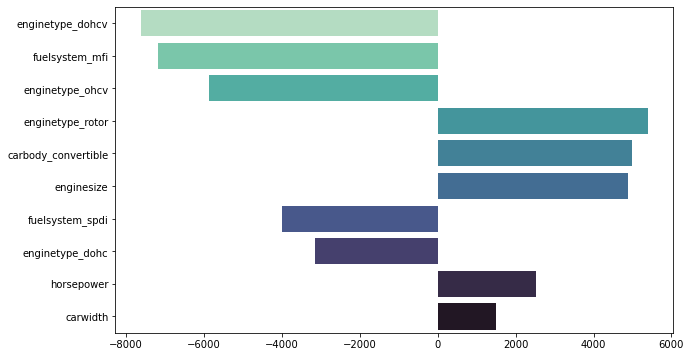

In [38]:
coef = res2.params.sort_values(key=abs, ascending=False).copy()
coef = coef.drop('const')

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y=coef.index, x=coef, palette='mako_r', ax=ax)

De esto podemos hacer algunas suposiciones:

* Aparecen varias dimensiones asociadas con la presencia de un tipo de motor en específico (`engine_X)`. DOHC (dual overhead cam), DOHCV (DOHC con configuración en V), OHCV (overhead cam en V) y rotor. Mientras que los primeros tres tienen coeficientes negativos (lo cual indica que el precio disminuye si están presentes), el último tiene asociado el coeficiente positivo de mayor valor, i.e., hace que el precio aumente. La razón detrás de esto es que los motores de rotor son un lujo en el mundo de los autos: como no usan pistones para generar movimiento, son más ligeros, eficientes y silenciosos. 

* Otra variable que tiene un coeficiente positivo considerable es la correspondiente a los carros convertibles (`carbody_convertible`). Esto es natural, ya que los convertibles suelen tener un precio mayor.

* Los caballos de fuerza (`horsepower`) y tamaño del motor (`enginesize`) tienen ambos coeficientes positivos. Estas dos características son mencionadas frecuentemente en los anuncios de automóviles, y suelen ser una característica importante para los clientes.

* Si bien ambos sistemas de inyección de gasolina (`fuelsystem_X`) tienen un coeficiente negativo, el de SPDI (single-point direct fuel injection) tiene una menor magnitud que el de MFI (multi-point fuel injection). Esto se debe a que SPDI es un sistema altamente especializado que consiste en inyectar combustible directamente en la cámara de combustión para tener el mejor rendimiento posible. Por otro lado, MFI es más común.

* El ancho del automóvil hace que su precio aumente. Los carros más grandes son por lo general más costosos.

# Conclusiones

Con el modelo obtenido, encontramos los factores que más afectan el precio de los autos. La mayoría de estos tienen que ver con los motores (ya sea su capacidad, potencia o diseño), por lo cual es importante que tanto los clientes como los fabricantes conozcan las diferencias entre cada uno de ellos, para poder tomar la mejor decisión al momento de adquir o comercializar un nuevo modelo de auto.